In [1]:
from google.colab import files
uploaded = files.upload()  # Upload the zipped dataset

Saving EuroSAT.zip to EuroSAT.zip


In [54]:
import zipfile
import os

# Unzip the uploaded file
zip_filename = list(uploaded.keys())[0]  # Get uploaded file name
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('./data')  # Extract to a "data" directory

# Set the directory for the dataset
train_dir = './data/2750'

In [65]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 10  # EuroSAT has 10 land cover classes


In [67]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images
    validation_split=0.2  # 20% validation data
)

In [68]:
train_dataset = datagen.flow_from_directory(train_dir,
                                            target_size=IMG_SIZE,
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            subset='training')

val_dataset = datagen.flow_from_directory(train_dir,
                                          target_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical',
                                          subset='validation')

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [69]:
# Load pretrained ResNet50 model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [70]:
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True


In [71]:
# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten the output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer

In [72]:
# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, batch_size=BATCH_SIZE)


Epoch 1/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 219s 241ms/step - accuracy: 0.2857 - loss: 2.1582 - val_accuracy: 0.1615 - val_loss: 7.1913
Epoch 2/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 157s 232ms/step - accuracy: 0.7663 - loss: 0.7561 - val_accuracy: 0.9337 - val_loss: 0.2216
Epoch 3/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 157s 232ms/step - accuracy: 0.8776 - loss: 0.4328 - val_accuracy: 0.9535 - val_loss: 0.1515
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 156s 232ms/step - accuracy: 0.9063 - loss: 0.3263 - val_accuracy: 0.9635 - val_loss: 0.1254
Epoch 5/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 170s 252ms/step - accuracy: 0.9244 - loss: 0.2724 - val_accuracy: 0.9665 - val_loss: 0.1083


In [74]:
# Save the trained model
model.save('resnet50_eurosat.h5')


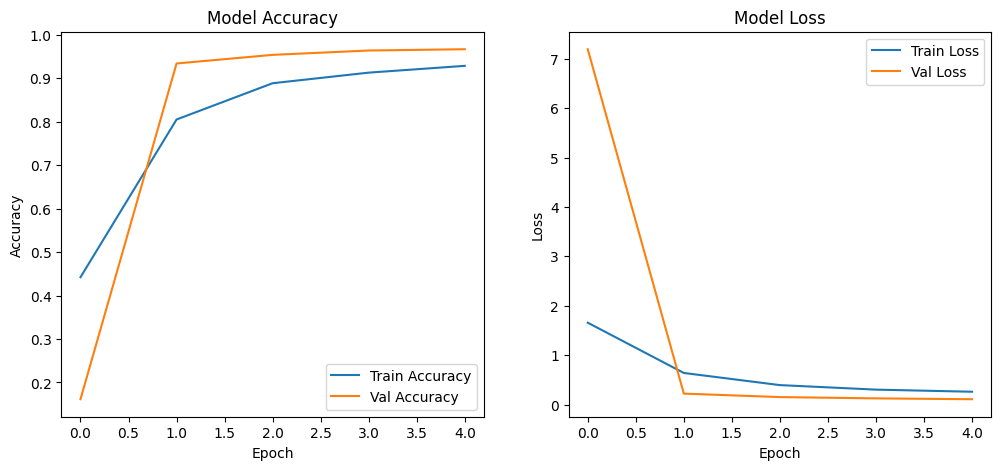

In [75]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━

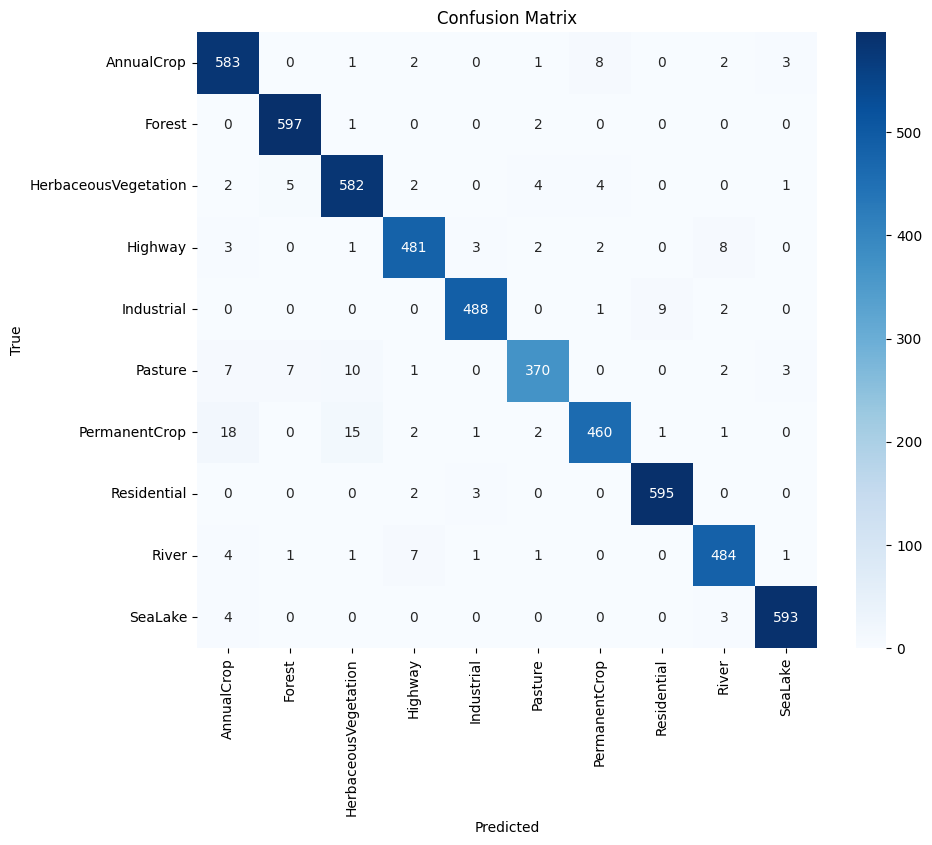

In [76]:
# --- EVALUATION ON VALIDATION SET ---

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_dataset.samples:  # Ensure we only take exact number of samples
        break

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.class_indices.keys(),
            yticklabels=val_dataset.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [77]:
# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_dataset.class_indices.keys()))


Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.97      0.95       600
              Forest       0.98      0.99      0.99       600
HerbaceousVegetation       0.95      0.97      0.96       600
             Highway       0.97      0.96      0.96       500
          Industrial       0.98      0.98      0.98       500
             Pasture       0.97      0.93      0.95       400
       PermanentCrop       0.97      0.92      0.94       500
         Residential       0.98      0.99      0.99       600
               River       0.96      0.97      0.97       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



In [78]:
from google.colab import files  # Only needed if using Google Colab

# Download the model (for local Jupyter Notebook or Colab)
files.download('resnet50_eurosat.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>